# Uncertainty Estimation Practical Part II


# Training Independent Subnetwork for Robust Prediction -- Havasi M et al.[[1]]

## Motivation
In the first part of this practical, we got hands-on experience working with the state-of-the-art Deep Ensembles(DE) method[[1]]. While this method achieves impressive performance[[2],[3]], it is not without limitations. There are three main issues:
* requires more training resources
* requires more time to evaluate
* requires more memory

Many works have tried to tackle one or several of these issues. For example, there are distillation methods that first train an ensemble and teach a single network to mimic the predictions of the ensemble[[4],[5],[6]]. This solves the last two problems, but not the first.

Another approach is for the members of the ensemble to share some of their weights with the other members[[1], [7]]. Depending on the amount of sharing, this can drastically reduce all three problems above.

In this part, we look at one such weight sharing method called MIMO[[1]].

## Abstract
Recent approaches to efficiently ensemble neural networks have shown that strong robustness and uncertainty performance can be achieved with a negligible gain in parameters over the original network. However, these methods still require multiple forward passes for prediction, leading to a significant computational cost. In this work, we show a surprising result: the benefits of using multiple predictions can be achieved `for free' under a single model's forward pass. In particular, we show that, using a multi-input multi-output (MIMO) configuration, one can utilize a single model's capacity to train multiple subnetworks that independently learn the task at hand. By ensembling the predictions made by the subnetworks, we improve model robustness without increasing compute. We observe a significant improvement in negative log-likelihood, accuracy, and calibration error on CIFAR10, CIFAR100, ImageNet, and their out-of-distribution variants compared to previous methods.

## Method
The idea of MIMO is to use a single network and encourage it to learn subnetworks that can be used as an ensemble. This is done by modifying the architecture for multiple inputs and outputs see the figure below(from the paper).
![](https://drive.google.com/uc?export=view&id=1E5eU1yGrCyMBQgKWWw-qrXEnJxXlh7ks)

During training, a network takes M inputs of potentially different classes as input and outputs M corresponding predictions using multiple heads. The network is optimized with a standard cross entropy loss function matching the output of a head to the class of the corresponding input.

At test time, the input is M copies of itself, and the the average of all the heads is the final prediction.


## Instructions

The following requires implementation:
* **Network**: Increase the size of the first and last layers. Convince yourself how the increase in the last layer corresponds to having multiple heads by looking at the provided ``predict_MIMO`` function.
+ **Training Step**: Update training code to take M inputs and modify the loss accordingly.
+ **Evaluation Step**: Update evaluation code to take M copies as input and average the output of the different heads.


[1]:https://arxiv.org/abs/2010.06610
[2]:https://arxiv.org/abs/1906.02530v2
[3]:https://arxiv.org/abs/1906.01620
[4]:https://arxiv.org/abs/1906.05419
[5]:https://arxiv.org/abs/2001.04694
[6]:https://arxiv.org/abs/1905.00076
[7]:https://arxiv.org/abs/2002.06715



## Classification on [toy dataset] using MIMO :
[toy dataset]: https://cs231n.github.io/neural-networks-case-study/

In [3]:
%reset -f

In [4]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt
from jax.scipy.special import logsumexp
import numpy as np
from jax.example_libraries import optimizers
from functools import partial

#from jax.config import config
# IMPORTANT NOTE:
# if you have got a NaN loss and/or have trouble debugging. Then, set
# jax_disable_jit to True. This will help you print out the variables.
#config.update('jax_disable_jit', False)

In [5]:
# Dataset
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

def generate_datasets(N,K,noise):
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels

    for j in range(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1.,N) # radius
        t = np.linspace(j*8,(j+1)*8,N) + np.random.randn(N)*noise * (r+1.0) # theta
        print(j, np.amin(t), np.amax(t))
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    X = jnp.array(X)
    y = jnp.array(y)
    y_onehot = one_hot(y, K)
    return X, y, y_onehot

0 -0.6210700567572351 9.160761050479454
1 7.506810982132371 16.88345105834359
2 15.192239293196302 25.21297645733773
Training X: (3000, 2)
Training y: (3000,)


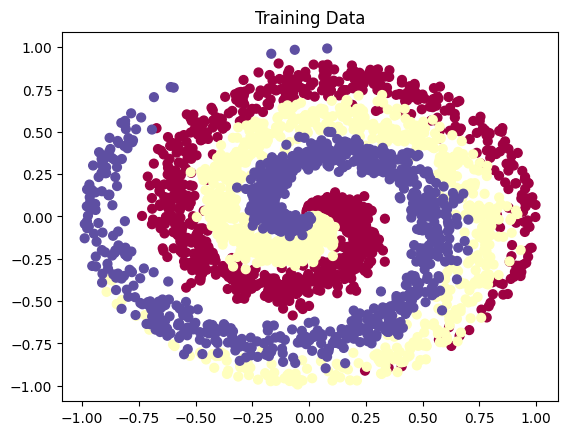

In [6]:
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

np.random.seed(0)
X, y, y_onehot = generate_datasets(N, K, noise=0.3)

# lets visualize the data:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.title("Training Data")
print("Training X:", X.shape)
print("Training y:", y.shape)

In [7]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-1):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def predict_MIMO(params, input):
    """
    The input is of shape (#nets, #examples, #input_dims)=(M,N,D).
    while the two outputs are of shape (#nets, #examples, #classes)=(M,N,K).
    """
    def _predict(params, input):
        M,D = input.shape
        input = input.reshape(M*D)
        activations = input
        for w, b in params[:-1]:
            outputs = jnp.dot(w, activations) + b
            activations = jax.nn.relu(outputs)

        final_w, final_b = params[-1]
        logits = jnp.dot(final_w, activations) + final_b
        logits = logits.reshape(M,-1)
        probs = jax.nn.softmax(logits, axis=1)
        return logits, probs

    logits, probs = vmap(_predict, in_axes=(None, 1))(params, input)
    logits, probs = jnp.transpose(logits, [1, 0, 2]), jnp.transpose(probs, [1, 0, 2])

    return logits, probs

@partial(jit, static_argnums=2)
def evalMIMO(params, inputs, M):
    N, D = inputs.shape
    """
    ==============================
    TODO: Implementation required.
    ==============================
    The ``inputs`` argument of this function is of shape (#examples, #input_dims)=(N,D).
    1. Create a new input of M copies of the input, resulting in shape (M,N,D).
    2. Use predict_MIMO with the input from 1 to get logits and probabilities, each of shape (M,N,K).
    3. Return a tuple of mean probabilities (shape (N,K)) and all probabilities (shape (M,N,K)).
    """

    input = jnp.tile(inputs, (M,1,1))
    logits, probabilities = predict_MIMO(params, input)
    mean_probabilities = jnp.mean(probabilities, axis=0)
    return mean_probabilities, probabilities

def batched_logsumexp(logits):
    """
    The input is of shape (M,N,K)=(#nets, #examples, #classes)
    The output is of shape (M,N)
    """
    def _logsumexp(logits):
        return logsumexp(logits, axis=1)
    return vmap(_logsumexp)(logits)

def lossMIMO(params, inputs, targets, M, wd, seed):
    N, D = inputs.shape
    """
    ==============================
    TODO: Implementation required.
    ==============================
    The ``inputs`` argument of this function is of shape (N,D)=(#examples, #input_dims).
    The ``targets` argument of this function is of shape (N,K)=(#examples, #classes).
    1. Create a randomly shuffled batch of shape (M,N,D)
    2. Use predict_MIMO to get logits and predictions, each of shape (M,N,K)
    3. Return the cross entropy loss for the M*N examples (scalar) and weight decay (see Part I)
    Tip: tile, take, random.permutation and batched_logsumexp could be handy
    """

    inputs = jnp.tile(inputs, (M,1,1))
    targets = jnp.tile(targets, (M,1,1))

    permutations = random.permutation(seed, jnp.arange(N))
    inputs = jnp.take(inputs, permutations, axis=1)
    targets = jnp.take(targets, permutations, axis=1)

    logits, probabilities = predict_MIMO(params, inputs)

    #ASK: how to use batched_logsumexp
    loss = -jnp.mean(jnp.sum(targets * jnp.log(probabilities + 1e-8), axis=-1)) + wd * jax.example_libraries.optimizers.l2_norm(params)

    return loss

@partial(jit, static_argnums=(4,5))
def update_mimo(params, x, y, opt_state, M, wd, seed):
    """ Compute the gradient for a batch and update the parameters """
    grads = grad(lossMIMO)(params, x, y, M, wd, seed)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state

def logging(params_mimo, X, y, M, log_acc_train, log_nll_train):
    mean, _ = evalMIMO(params_mimo, X, M)

    y_pred = jnp.argmax(mean, axis=1)
    train_acc = jnp.mean(y_pred == y)
    y_conf = mean[np.arange(y.shape[0]),y]
    train_nll = -jnp.mean(jnp.log(y_conf))

    log_acc_train.append(train_acc)
    log_nll_train.append(train_nll)


In [8]:
M = 4

"""
==============================
TODO: Implementation required.
==============================
1. Update size of first layer to handle more inputs.
2. Update size of last layer to get multiple heads.
"""
layer_sizes = [2*M, 150, 150, 3*M]

num_epochs = 2000
step_size = 0.1
wd = 1e-3

log_acc, log_nll = [], []

opt_init, opt_update, get_params = optimizers.adam(step_size)
params_mimo = init_network_params(layer_sizes, random.PRNGKey(0))
opt_state_all = opt_init(params_mimo)

key = random.PRNGKey(0)
for epoch in range(num_epochs):
    key, seed = random.split(key)

    params_mimo = get_params(opt_state_all)
    params_mimo, opt_state_all = update_mimo(params_mimo, X, y_onehot, opt_state_all, M, wd, seed)
    logging(params_mimo, X, y, M, log_acc, log_nll)


    print('\r', f'[Epoch {epoch+1}]: Train Acc: {log_acc[-1]:.3f} | Train NLL: {log_nll[-1]:0.3f}', end='')

 [Epoch 2000]: Train Acc: 0.941 | Train NLL: 0.163

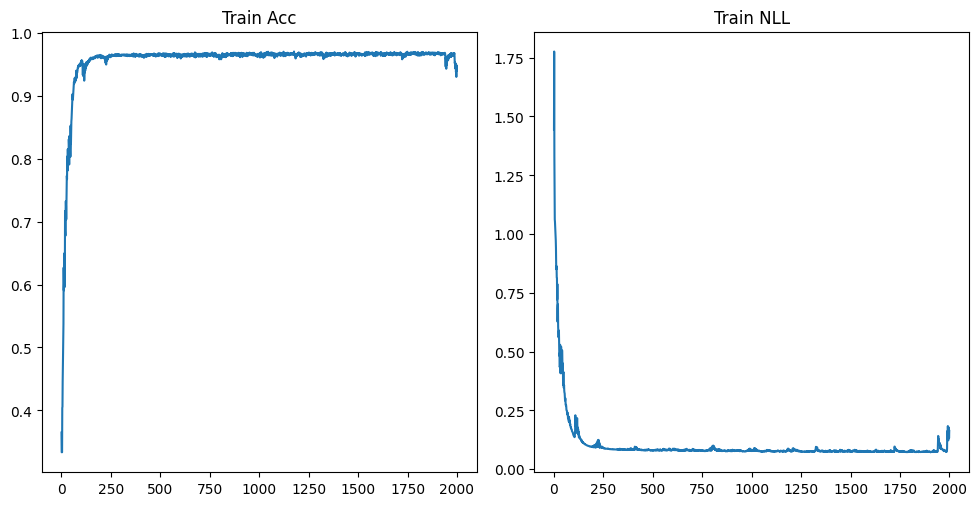

In [9]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout()
axes[0].plot(log_acc)
axes[1].plot(log_nll)
axes[0].title.set_text('Train Acc')
axes[1].title.set_text('Train NLL')

In [10]:
# Visualization code
def entropy(preds):
    preds = np.clip(preds, 1e-7, 1.0)
    return -np.sum( preds * np.log(preds), axis=1)

def js_terms(distributions):
    return entropy(np.mean(distributions, axis=0)), np.mean([entropy(p) for p in distributions], axis=0)

def visualize_predictions(X, y, params_list, min=-2.0, max=2.0, res=200, num_nets=1):
    xs = np.linspace(min, max, res)
    ys = np.linspace(min, max, res)
    N, M = len(xs), len(ys)
    xy = np.asarray([(_x,_y) for _x in xs for _y in ys])
    num_samples = xy.shape[0]

    predictions_ensemble, probs = evalMIMO(params_list, xy, num_nets)
    predictions = [probs[i,:,:] for i in range(probs.shape[0])]
    total, data = js_terms(predictions)

    indices = np.unravel_index(np.arange(num_samples), (N,M))

    Z, Z2, Z3 = np.zeros((N,M)), np.zeros((N,M)), np.zeros((N,M))
    Z[indices] = jnp.argmax(predictions_ensemble, axis=1)
    Z2[indices] = total - data
    Z3[indices] = data

    fig, axes = plt.subplots(2,2, figsize=(10,10))
    axes = axes.flatten()
    fig.tight_layout()

    axes[0].scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    axes[1].contourf(xs, ys, Z.T, cmap=plt.cm.Spectral, levels=50)
    axes[2].contourf(xs, ys, Z3.T, cmap='magma',levels=50)
    axes[3].contourf(xs, ys, Z2.T, cmap='magma', levels=50)

    axes[0].set_xlim([min, max]); axes[0].set_ylim([min, max]);

    axes[0].title.set_text('Dataset')
    axes[1].title.set_text('Mean')
    axes[2].title.set_text('Data Uncertainty')
    axes[3].title.set_text('Knowledge Uncertainty')

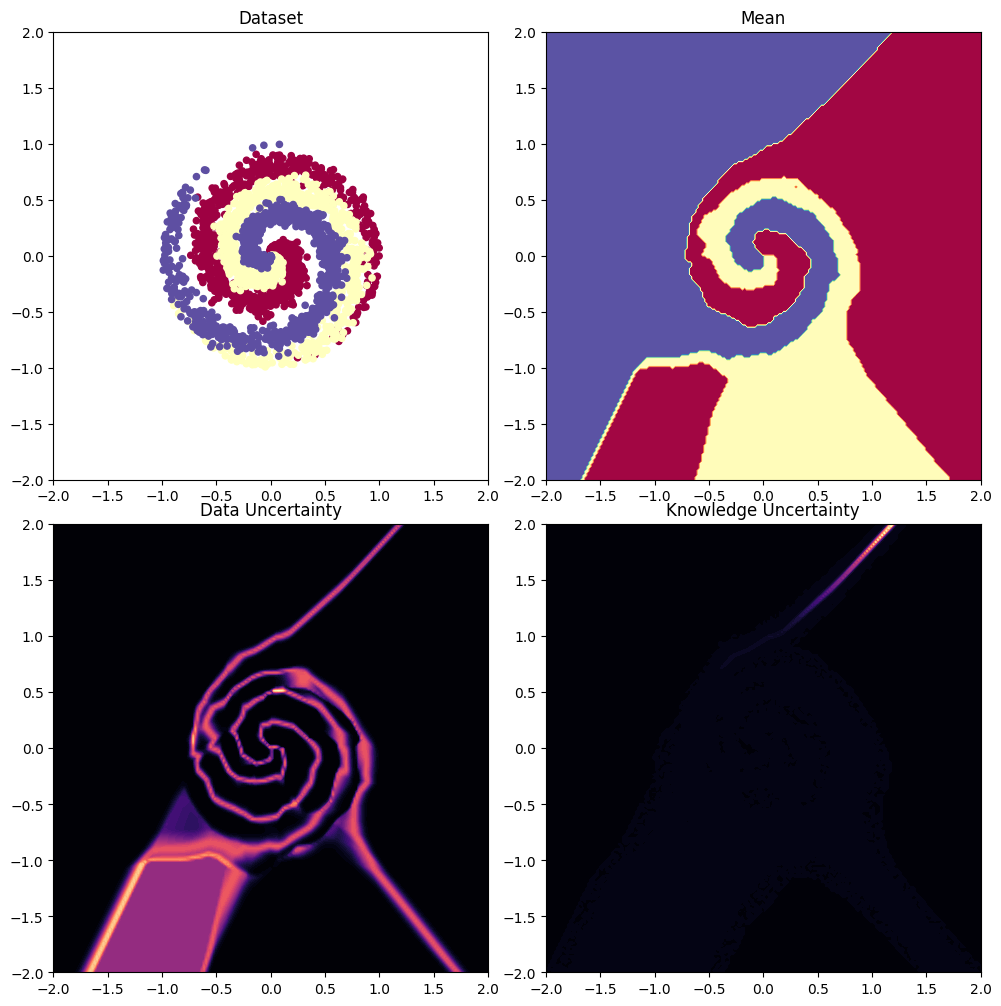

In [11]:
visualize_predictions(X, y, params_mimo, num_nets=M)

where dark to light increases in value.

**Discussion points:**
* In terms of the discussion points in Part I, is the MIMO ensemble behaving as the Deep Ensemble?
* Compared to the Deep Ensemble, how is the entropy of the mean prediction and the diversity of MIMO affected by increasing M?
* Finally, it is valuable for us to know how long did it take you to complete this practical?


## Image Classification (Optional)
We provide code in ``classification_mnist_pytorch.py`` for training a single network to classify images of numbers (MNIST). For bonus points, adapt this code to use any of these two ensembling techniques we have learned about in this practical.
